In [109]:
%matplotlib widget

from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import numpy as np

Finally we arrived to this stage. Previously, we have used the one vs one and one vs rest strategies to convert our multi classification problem to multiple binary classification problems. We also tried nearest neighbor techniques like knn classifier and weighted knn classifier. We have shown that these previous strategies are usually good when used in the proper circumstances. We also showcased many flaws with previous methods. These range from accuracy issues, numeric instability, and performance problems. Today, we will showcase a proper softmax classification method that will solve all of these previous issues if used correctly. We also have shown the softmax derivation to get some intuition in how the loss function will work. Leaving the details till later, we start using some more complicated datasets like handwritten digits. This is known as the Optical recognition of handwritten digits dataset provided by Scikit. With this, we can check how well a basic softmax loss will fare against this dataset. For now, let's start by visualizing some samples of the dataset.

In [110]:
# load the full dataset and display it
dataset = load_digits() # make sure to shuffle the data so no local patterns emerge
feature_names = dataset.feature_names
target_names = dataset.target_names
data = dataset.data
target = dataset.target

In [111]:
print("Feature names:", feature_names)
print("Target Categories:", target_names)
print("Features: ", data.shape, data.dtype)
print("Classes:", target.shape, target.dtype)

print("Features: ", data)
print("Classes:", target)
print("Feature range:", np.min(data).astype(np.int32), np.max(data).astype(np.int32))
print("Feature type:",data.dtype)
print("Target type:",target.dtype)

Feature names: ['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6', 'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0', 'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4', 'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1', 'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6', 'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3', 'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7']
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (1797, 64) float64
Classes: (1797,) int32
Features:  [[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ..

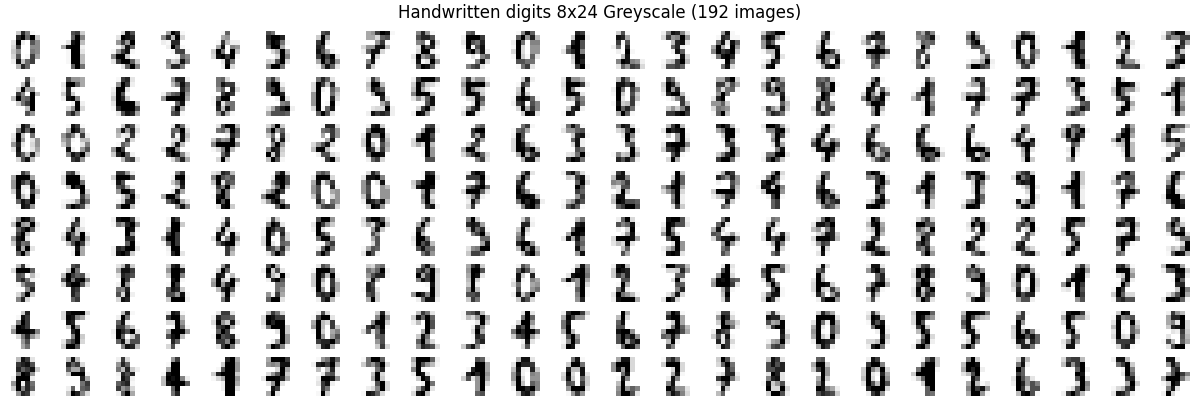

In [112]:
wsize = 24
hsize = 8
fig, axes = plt.subplots(hsize,wsize,figsize=(wsize/2,hsize/2),layout="constrained")

c = 0
for i in range(hsize):
    for j in range(wsize):
        axes[i][j].imshow(data[c].reshape((8,8)), interpolation='none', cmap=cm.Greys)
        axes[i][j].axis('off')
        c += 1
plt.suptitle(f"Handwritten digits {hsize}x{wsize} Greyscale ({wsize*hsize} images)")
plt.show()

Here are the first 192 images in the dataset. The images are only 8x8 so they're very low quality but it's still very clear to us what each digit the image represents. Let's split the dataset now.

In [113]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=1) # 33 % split
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (1203, 64) (1203,)
Test: (594, 64) (594,)


In [114]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    max_value = np.max(data_unscaled)

    data_scaled = np.array(data_unscaled)
    data_scaled = data_scaled / max_value
    # min max normalization
    
    return data_scaled

X_train = feature_scale(X_train, scaled=True)
print(X_train)

[[0.     0.     0.     ... 0.875  0.     0.    ]
 [0.     0.     0.4375 ... 0.375  0.     0.    ]
 [0.     0.     0.5    ... 0.25   0.     0.    ]
 ...
 [0.     0.     0.4375 ... 0.8125 0.125  0.    ]
 [0.     0.     0.     ... 1.     0.0625 0.    ]
 [0.     0.     0.5    ... 0.     0.     0.    ]]


As usual, we want to feature scale the data in order for gradient descent to perform well. Normally, we would use std normalization as it considers each feature separately and scales the features well. However, here we are dealing with 0-16 values as intensities for the digits. Each feature is a pixel in the image. From this, it's clear that there are many values to represent a specific digit on the image. It could be slanted, rotated, streched, etc. The image however will be completely different even though the digit will be the exact same. So it's ideal to understand that each specific feature is actually useless in the full context of all features. It's the way the different pixels are connected to each other is what matters. With this, the best thing to do is to feature scale the entire image at one by dividing by the full range of the data. This will scale the data between 0 and 1 which will work fine with gradient descent. This is similar to min max normalization.

In [115]:
def add_bias_weight(data):
    m = data.shape[0]
    ones_feature = np.ones(m).reshape((-1,1)) # create a single feature of ones
    data_bias = np.hstack([data, ones_feature])
    return data_bias

X_train = add_bias_weight(X_train)
print(X_train)

[[0.     0.     0.     ... 0.     0.     1.    ]
 [0.     0.     0.4375 ... 0.     0.     1.    ]
 [0.     0.     0.5    ... 0.     0.     1.    ]
 ...
 [0.     0.     0.4375 ... 0.125  0.     1.    ]
 [0.     0.     0.     ... 0.0625 0.     1.    ]
 [0.     0.     0.5    ... 0.     0.     1.    ]]


From here on out, we need to drastically simplify our equations. Since softmax is an expensive function and we are dealing with multiple weights per category, it helps to simplify the model as much as possible. It turns out that to simplify we can actually remove the bias term from the equations and put it in the weights instead. The feature associated with the bias weight all become 1. This is a small trick to still keep the bias in the model, and it simplifies the model quite a bit. We can now remove the bias term completely. 

In [116]:
def softmax(x):
    ez = np.exp(x)
    return ez / np.sum(ez, axis=1).reshape((-1,1))

Prediction will now go through the softmax function. Remember that the prediction now gives a vector of probabilities for each example. If we consider over all examples, we now get a matrix $m \times k$ where $m$ is the training examples and $k$ is the categories. The softmax is defined as $a_j = \frac{e^{z_j}}{ \sum_{k=1}^{N}{e^{z_k} }} $. We just perform this over each example and each category.

In [117]:
def predict(w, x, epsilon=1e-15):
    prediction = np.matmul(x, w) # m k
    softmax_predict = softmax(prediction) # pass it through a softmax
    prediction = np.clip(softmax_predict, epsilon, 1 - epsilon) # clip to avoid overflow issues
    return prediction

We also clip the prediction to avoid overflow issues. This is also something we did after passing the value in the sigmoid. The same pattern repeats here since the function outputs are probabilities between 0 and 1. The cost function here is very similar to logistic loss. In logistic loss, we used $-log(p1)$ to compute the loss for probability $p1$. Since there are multiple probabilities, we need weights for each probability value. The loss becomes 
\begin{equation}
  L(\mathbf{p},y)=\begin{cases}
    -log(p_1), & \text{if $y=1$}.\\
        &\vdots\\
     -log(p_k), & \text{if $y=k$}
  \end{cases}
\end{equation}
Then the full cost function becomes
$$
J(\mathbf{w},b) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{j=1}^{k}  1\left\{y^{(i)} == j\right\} \log \frac{e^{z^{(i)}_j}}{\sum_{p=1}^k e^{z^{(i)}_p} }
$$
The $1\left\{y^{(i)} == j\right\}$ is an indicator function where if $y^{(i)} == j$ then the expression becomes a $1$ or $0$ otherwise. Of course, we want to fully vectorize the cost function and the gradients for softmax. This is hard with the indicator function. Instead of using the indicator function we use a one hot encoded matrix $(O_{ij})$ to achieve the same output. We one hot the target labels to get the one hot matrix. Then, the new cost function simplifies to $$J(\mathbf{w},b) = -\frac{1}{m}  \sum_{i=1}^{m} \sum_{j=1}^{k}  O_{ij} \log \frac{e^{z^{(i)}_j}}{\sum_{p=1}^k e^{z^{(i)}_p} }$$

In [118]:
def onehot_matrix(a):
    a = a.flatten()
    categories = np.unique(a).shape[0]
    return np.eye(categories)[a]

Here, we see that if we use one hot matrix, the code simplifies a lot just like the equation. 

In [119]:
def log_loss_cost(w,x,y):
    onehot = onehot_matrix(y) # m k
    softmax_prob = predict(w, x) # m k
    overk = onehot * np.log(softmax_prob) # m k
    overm = np.sum(overk, axis=1) # m
    return -np.mean(overm) # 1

Now, computing the gradient is tedious as there are many derivatives to take. The final result once we compute the gradient however is very simple. The gradient with respect to a specific weight is $\frac{\partial L}{\partial w_{ji}} = x_j( \^{y_i} - y_i)$. $i$ is the $i$-th category while $x_j$ refers to the $j$-th feature of the $x$ input vector. $\^{y_i}$ is the $i$-th predicted probability while $y_i$ is the observed label. This is the gradient of the categorical loss function and it simplifies a lot once you compute it. Of course, this is for a single weight, so we need to apply this over all the weights per each category and over all the training examples to get the average gradient. Of course, the vectorized equation as a result is also simple. It becomes $ \frac{\partial L}{\partial W} = \frac{1}{m}X^T(\^{Y}-Y)$. The resulting code is very simple and easy to understand.

In [120]:
def compute_gradients(w,x,y):
    m = x.shape[0] # number of training examples
    onehot = onehot_matrix(y) # m k
    softmax_prob = predict(w, x) # m k
    diff = softmax_prob - onehot # m k
    dw = np.matmul(x.T, diff) / m # n k
    return dw

In [121]:
def show_cost_graph(costs, title, color):
    iterations = costs.shape[0]
    iteration_array = np.arange(0, iterations, dtype=np.int32)
    
    # graph the cost after updating the model
    fig, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Current Iteration")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration_array, costs, color=color)

Previously, we zeroed out the weights. We can also randomize the weights so every run will have different descent times.

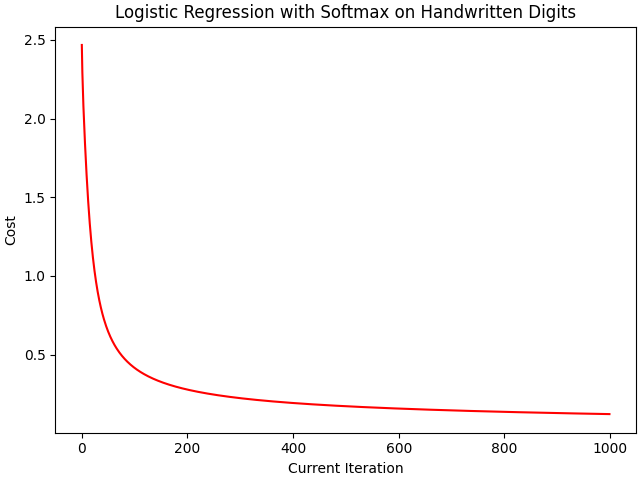

In [122]:
def gradient_descent(x, y, gradient_func, cost_func, learning_rate=0.01, max_iterations=1000):
    y = y.reshape((-1,1))
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    k = np.unique(y).shape[0] # number of categories

    w = np.random.random((n, k)) # n by k weights
    # initialize model parameters to random values
    costs = np.empty(0)

    for i in range(max_iterations):
        dw = gradient_func(w,x,y)
        w -= learning_rate * dw
        # update the weights
        
        current_cost = cost_func(w,x,y)
        costs = np.append(costs, current_cost)
        # add to array for visualization
    return w, costs
weights, costs = gradient_descent(X_train, y_train, compute_gradients, log_loss_cost, learning_rate=0.5, max_iterations=1000)
show_cost_graph(costs, "Logistic Regression with Softmax on Handwritten Digits", "red")

In [123]:
print("Initial cost",costs[0])
print("Final cost",costs[-1])

Initial cost 2.4679839682431814
Final cost 0.12142083448634292


Okay the cost does improve but it doesn't improve that much. This decrease looks quite big but it's likely very deceiving. Let's print the accuracy on the test data set to see how many samples it classifies correctly.

In [124]:
def get_prediction_categories(probabilities):
    return np.argmax(probabilities,axis=1)

In [125]:
train_samples = X_train.shape[0]
prediction_train_set_prob = predict(weights, X_train)
prediction_train_samples = get_prediction_categories(prediction_train_set_prob)
score_percentage = accuracy_score(y_train, prediction_train_samples) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(y_train, prediction_train_samples, normalize=False))
print("Misclassifications:",train_samples - misclassifications)

Accuracy: 97.59 %
Misclassifications: 29


The accuracy looks high here. This is for the training set obviously so it's unfair. Let's compute the accuracy on the test set instead and see how it performs. We obviously rescale the test set just like the training set.

In [126]:
X_test = feature_scale(X_test, scaled=True)
X_test = add_bias_weight(X_test)
print(X_test)

[[0.     0.     0.375  ... 0.     0.     1.    ]
 [0.     0.5    0.8125 ... 0.     0.     1.    ]
 [0.     0.     0.25   ... 0.     0.     1.    ]
 ...
 [0.     0.     0.3125 ... 0.     0.     1.    ]
 [0.     0.     0.     ... 0.     0.     1.    ]
 [0.     0.     0.25   ... 0.     0.     1.    ]]


In [127]:
test_samples = X_test.shape[0]
prediction_test_set_prob = predict(weights, X_test)
prediction_test_samples = get_prediction_categories(prediction_test_set_prob)
score_percentage = accuracy_score(y_test, prediction_test_samples) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(y_test, prediction_test_samples, normalize=False))
print("misclassifications:",test_samples - misclassifications)

Accuracy: 96.8 %
misclassifications: 19


Wow, the accuracy is still very high. We achieved ~$96$% by using the softmax. We should verify with other algorithms as well. Let's use scikit's softmax regression to see what accuracy it achieves.

In [128]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [129]:
y_train_scikit = model.predict(X_train)
score_percentage = accuracy_score(y_train, y_train_scikit) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(y_train, y_train_scikit, normalize=False))
print("Misclassifications:",train_samples - misclassifications)

Accuracy: 98.5 %
Misclassifications: 18


On the training set, scikit achieved ~$98$% so a bit higher than ours. Let's check the test set to see what the accuracy is. 

In [130]:
y_test_scikit = model.predict(X_test)
score_percentage = accuracy_score(y_test, y_test_scikit) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(y_test, y_test_scikit, normalize=False))
print("Misclassifications:",test_samples - misclassifications)

Accuracy: 97.31 %
Misclassifications: 16


Ok it is a bit higher on average than our method. There could be many reasons for this such as different gradient descent strategies which converge faster. Scikit by default also regularizes the weights which we're not doing right now. Regardless, it's interesting to see such a good accuracy. Anyways, let's see which digits it misclassified from our test set.

In [131]:
y_difference = prediction_test_samples == y_test
misclassified_indices = np.argwhere(y_difference==False).reshape(-1)
misclassifications = misclassified_indices.shape[0]
print(misclassified_indices) # indices where we misclassified

[ 21 108 116 173 174 248 249 267 281 348 394 400 462 523 537 545 576 579
 591]


This array has all the misclassified indexes in the test set array. We just need to display these images to see how they look like.

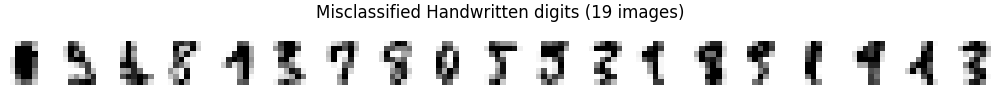

In [132]:
fig, axes = plt.subplots(1,misclassifications,figsize=(10,1),layout="constrained")

X_actual_test = X_test[:,:-1] # remove the bias feature we manually added
for i in range(misclassifications):
        axes[i].imshow(X_actual_test[misclassified_indices[i]].reshape((8,8)), interpolation='none', cmap=cm.Greys)
        axes[i].axis('off')
plt.suptitle(f"Misclassified Handwritten digits ({misclassifications} images)")
plt.show()

Here, i'm just displaying everything the custom model has misclassified. Here, it's clear that there are certain digits which could be considered another digit easily. Some 5's look like 3's and some 9's look like 1's. Sometimes the loops in the digits get flattened so the model fails to recognize the true digit. Other times the unclear spaces look like combined loops. These are just some examples on why the model fails to classify these correctly. To fix these, other techniques must be employed such as neural networks. Anyways, since this is still a single layer, let's visualize some aspects of the model. Let's compare the weights for each feature to see which weights as more important. Since this is still logistic regression, we can visualize the weight matrix associated with different categories which is different digits.

In [133]:
categories = weights.shape[1]
scaler = MinMaxScaler()
scaler.fit(weights) # fit the weights
scaled_weights = scaler.transform(weights) # get new scaled weights

We first scale the weights using min max normalization between 0 and 1. This will make it easier to visualize later on. Of course, imshow will automatically scale the weights anyways so above code isn't necessary, but it's a good idea to do it for other graphing libraries as well.

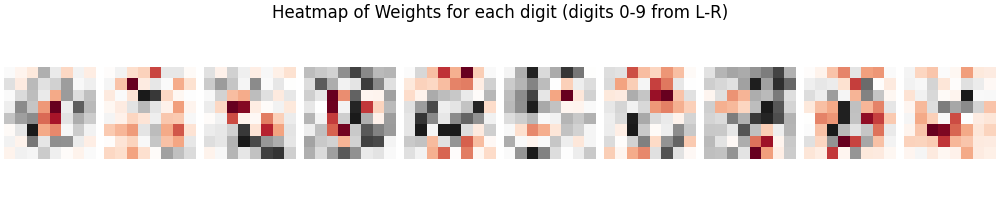

In [134]:
fig, axes = plt.subplots(1,categories,figsize=(10,2),layout="constrained")
scaled_weightsT = scaled_weights.T
scaled_weightsT = scaled_weightsT[:,:-1] # remove the bias feature we manually added
for i in range(categories):
        axes[i].imshow(scaled_weightsT[i].reshape((8,8)), interpolation='none', cmap=cm.RdGy)
        axes[i].axis('off')
plt.suptitle(f"Heatmap of Weights for each digit (digits 0-9 from L-R)")
plt.show()

This is really interesting looking at this. The black pixels represent the high positive weights which the model thinks as important and the red pixels represent the low negative weights which the model will penalize if seen. This is possible since the weights can be both positive and negatives. This explains some decisions the model is making. For digit 0, it actually mapped the circle well. For 1 and 2, it chooses the top vertical pixels and bottom horizontal pixels respectively as the important pixels used to categorize the 1 and 2 digits. 5 is also very obvious. 6 has a bottom semi-circle which should make sense. The model also figure out both diagonal and horizontal lines for 7th digit. 8 looks very clear as well. Only things that aren't obvious here are 4 and 9, which we don't know if the model gets lucky on classifying them or actually classifies them properly. With this heatmap, we can see a lot of pixels the model prefers to look at in classifying so it's insightful. To see if the model gets lucky with certain digits, we can use a visualize a confusion matrix with a heatmap.

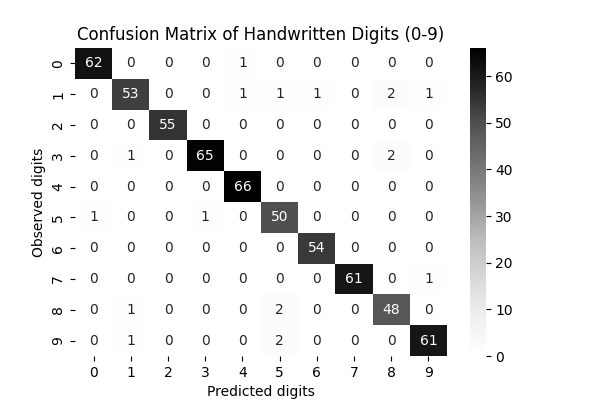

In [135]:
cm_digits = confusion_matrix(y_test, prediction_test_samples)
plt.figure(figsize=(6, 4))
ax = sb.heatmap(cm_digits,annot=True, fmt='d', cmap='Greys')
plt.title("Confusion Matrix of Handwritten Digits (0-9)")
plt.ylabel("Observed digits")
plt.xlabel("Predicted digits")
plt.show()

We use scikit's confusion matrix function to get the confusion matrix. The confusion matrix is a matrix that dictates the counts between the predicted classes and observed classes. The diagonals are the target here so we want all the predictions to be in the diagonal. The non-diagonals are misclassifications so we can get some insights into where the model is predicting incorrectly. We also use seaborn's heatmap to display the counts in the plot. Observing the plot, it does look like most values are in the diagonals which is what we expect as we got such a high accuracy. Looking at the digits, there are some minor discrepancies here. Firstly, it looks like the custom model thinks that some 8's and some 9's are 5's. Some 3's it thinks are 8's which makes sense as 3's and 8's are very similar. Other than that, the rest looks like noise. In general, this is what we want from a confusion matrix. We want no biases in the dataset and the model to classify accurately. Speaking of biases, it's also important to visualize the counts of different digits in the test set. This will help us to see if there are more specific digits in the test set than there should be. 

Text(0.5, 0.98, 'Frequency of digits in test set (0-9)')

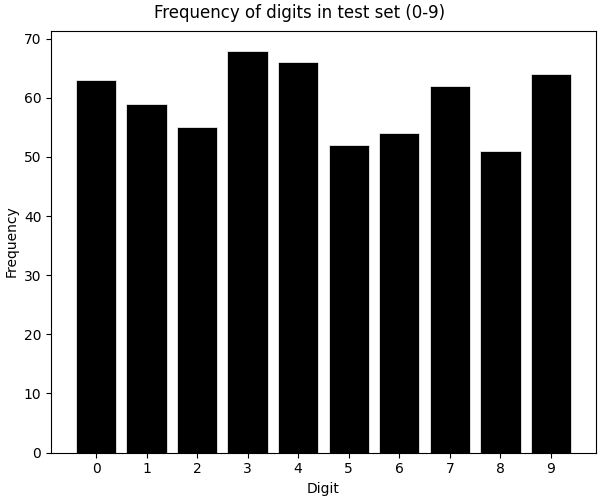

In [136]:
test_counts = np.bincount(y_test)
fig, ax = plt.subplots(figsize=(6,5),layout="constrained")
ax.bar(target_names, test_counts, linewidth=0.5, edgecolor="white",color="black")
ax.set_xlabel("Digit")
ax.set_ylabel("Frequency")
ax.set_xticks(range(10))
fig.suptitle(f"Frequency of digits in test set (0-9)")

These are the frequencies of each digit in the test set. It looks very pronounced but there isn't really any bias here. The dataset is well formed here. From this, if we have a lot more data, we can expect nearly the same results from the confusion matrix. It is important to check lack of data for specific categories and that's what this is doing. 